## Demonstration of Model Selection in Multiclass Classification

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook demonstrates the model selection process using a *Random Search* strategy. A multiclass classification problem with a synthetically created dataset of examples is used. This rather simple problem has been chosen for the sake of illustration and computational ease. We use the [`kerastuner`](https://keras.io/keras_tuner/) framework for model selection (hyperparameter tuning).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperParameters, RandomSearch

### Generate Dataset

In the following, a synthetic dataset with $N$ examples from $C$ classes is generated by using the function [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification). The categorical class labels are one-hot encoded, and the dataset is split into a training and validation subset.

In [2]:
N = 2000  # total number of examples
C = 3  # number of classes

X, Y = make_classification(n_samples=N,
                           n_classes=C,
                           n_clusters_per_class=1,
                           n_features=2,
                           n_redundant=0,
                           n_informative=2,
                           random_state=42)

# one-hot encoding of class labels
Y1h = to_categorical(Y, C)

# split into training/validation subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y1h, test_size=0.2)

### Definition of Model and Setup of Model Selection

The architecture of the model and its hyperparameters are defined in a parametric manner using functionality from `kerastuner`. The number of hidden layers, their number of neurons, the activation functions, an optional dropout layer and the learning rate of the Adam optimizer have been chosen as parameters to be considered in the model selection process.

In [3]:
def build_model(hp):

    model = Sequential()
    model.add(Input(shape=(2,)))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(Dense(units=hp.Int(f"units_l{i}", min_value=16, max_value=128, step=16),
                        activation=hp.Choice("activation", ["relu", "tanh"])))

        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))

    model.add(Dense(C, activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-4,
                             max_value=1e-2, sampling="log")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy", metrics=["accuracy"])

    return model


build_model(HyperParameters())

<Sequential name=sequential, built=True>

Now the model selection process is defined. We use the Random Search strategy with 20 randomly selected sets from all potential hyperparameters. The parameters to be optimized, as well as their ranges are summarized below.

In [4]:
max_trials = 20

tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=max_trials,
    executions_per_trial=2,
    overwrite=True,
    directory="tuner_results",
    project_name="multiclass")

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_l0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Model Selection

The candidate models are trained and evaluated for random selections of hyperparameters.

In [5]:
stop_early = EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(X_train, Y_train, epochs=100, validation_data=(
    X_test, Y_test), callbacks=[stop_early], batch_size=32)

Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.8899999856948853

Best val_accuracy So Far: 0.9487499892711639
Total elapsed time: 00h 01m 22s


Lets take a look at the classification accuracies of the trained candidate models on the validation subset.

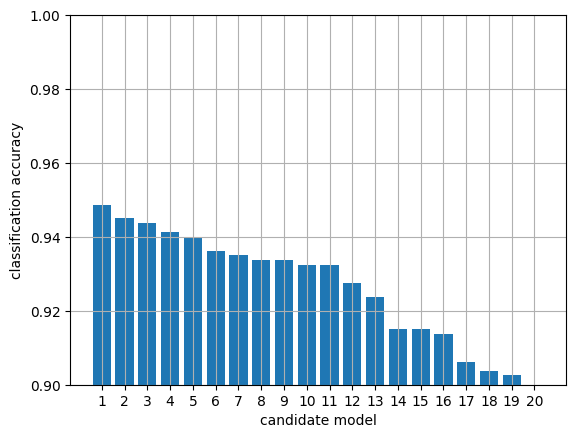

In [6]:
best_trials = tuner.oracle.get_best_trials(max_trials)
scores = [trial.score for trial in best_trials]


yaxis = np.arange(1, max_trials+1)
plt.bar(yaxis, scores)

plt.ylim([0.9, 1])
plt.xticks(yaxis)
plt.xlabel('candidate model')
plt.ylabel('classification accuracy')
plt.grid()

And the parameters associated with the five best models

In [7]:
tuner.results_summary(num_trials=5)

Results summary
Results in tuner_results/multiclass
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 17 summary
Hyperparameters:
num_layers: 2
units_l0: 96
activation: relu
dropout: True
lr: 0.004850371042724017
units_l1: 96
units_l2: 96
Score: 0.9487499892711639

Trial 10 summary
Hyperparameters:
num_layers: 3
units_l0: 16
activation: relu
dropout: False
lr: 0.0029006203636140547
units_l1: 112
units_l2: 48
Score: 0.9449999928474426

Trial 12 summary
Hyperparameters:
num_layers: 1
units_l0: 96
activation: relu
dropout: True
lr: 0.005450896567054627
units_l1: 128
units_l2: 48
Score: 0.9437499940395355

Trial 07 summary
Hyperparameters:
num_layers: 1
units_l0: 64
activation: relu
dropout: False
lr: 0.007168071802725966
units_l1: 80
units_l2: 80
Score: 0.9412499964237213

Trial 02 summary
Hyperparameters:
num_layers: 3
units_l0: 128
activation: relu
dropout: False
lr: 0.0007022600695706456
units_l1: 16
units_l2: 64
Score: 0.9399999976158142


### Final Model

The best model from the model selection process is taken as final model. Its architecture is illustrated below

In [8]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 96)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,891 (38.64 KB)

 Trainable params: 9,891 (38.64 KB)

 Non-trainable params: 0 (0.00 B)

The final model is retrained

In [9]:
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), callbacks=[stop_early], epochs=100, batch_size=32)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8218 - loss: 0.5612 - val_accuracy: 0.9250 - val_loss: 0.2427
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9196 - loss: 0.2701 - val_accuracy: 0.9150 - val_loss: 0.2594
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9298 - loss: 0.2250 - val_accuracy: 0.9200 - val_loss: 0.2386
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9371 - loss: 0.2144 - val_accuracy: 0.9325 - val_loss: 0.2458
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9376 - loss: 0.2112 - val_accuracy: 0.9325 - val_loss: 0.2317
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9461 - loss: 0.2008 - val_accuracy: 0.9300 - val_loss: 0.2328
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9412 - loss: 0.2004 - val_accuracy: 0.9225 - val_loss: 0.2679
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.2344 - val_accuracy: 0.9325 - v

Lets take a look at the loss and accuracy over the epochs

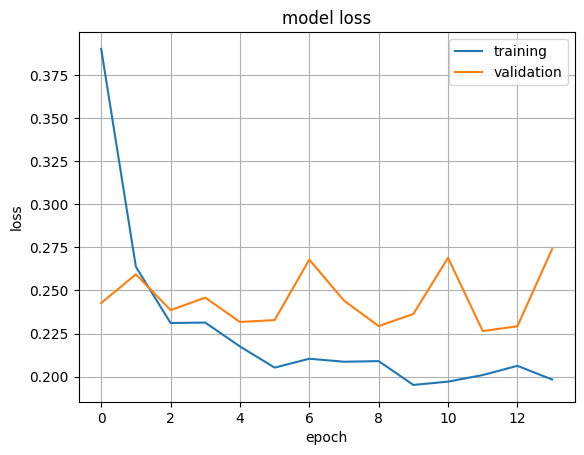

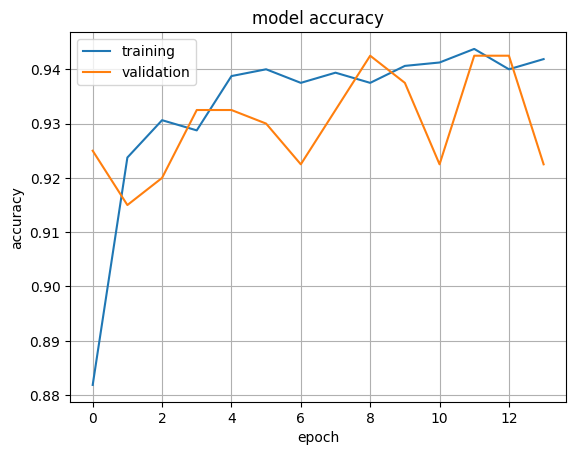

In [10]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')
plot_history(history, 'accuracy')

**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.